In [1]:

"""
copy from kaggle
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # 用于显示图片
import matplotlib.image as mpimg  # 用于读取图片
import seaborn as sns  # 画图
%matplotlib inline 

np.random.seed(2)  # 随机种子

from sklearn.model_selection import train_test_split  # 分割训练集和测试集
from sklearn.metrics import confusion_matrix # 混淆矩阵
import itertools # 创建迭代器

from keras.utils.np_utils import to_categorical #将类别值进行onehot编码 convert to one-hot-encoding
from keras.models import Sequential# 序贯模型
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D  # 全连接层、正则化、展平->一维、卷积层、池化层
from keras.optimizers import RMSprop # 优化器
from keras.preprocessing.image import ImageDataGenerator #ImageDataGenerator()是keras.preprocessing.image模块中的图片生成器，同时也可以在batch中对数据进行增强，扩充数据集大小，增强模型的泛化能力。比如进行旋转，变形，归一化等等。
from keras.callbacks import ReduceLROnPlateau # 当评价指标不再提升时，减少学习率。当学习停滞时，减少2倍或10倍的学习率常常能获得较好的效果。该回调函数检测指标的情况，如果在patience个epoch中看不到模型性能提升，则减少学习率


sns.set(style='white', context='notebook', palette='deep') # 设置图样式等参数

Using TensorFlow backend.


In [2]:
# Load the data
train = pd.read_csv("./train.csv") # 加载训练集
test = pd.read_csv("./test.csv")   # 加载测试集

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

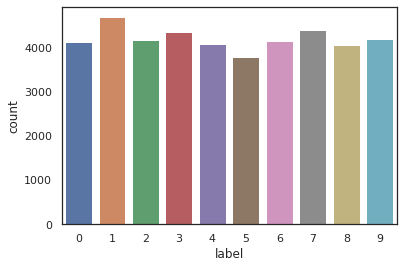

In [3]:
Y_train = train["label"]  # 训练集label

# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1)  # 删除训练集label,留下特征

# free some space
del train # 释放内存

g = sns.countplot(Y_train) # 使用直方图展示一列或两列的类别值分布

Y_train.value_counts()# 展示类别和对应的数量

In [4]:
# Check the data
X_train.isnull().any().describe()  # isnull()判断缺失值，生成所有数据的true/false矩阵，isnull().any()会将所有列进行统计，列中包含空值，该列为True。可指定参数axis=1，对行进行统计，
# 将信息进行汇总。count为总统计数；unique为种类（由于该数据中没有空值，全为False，故只有1类）；top为最多的种类；freq为最多种类出现频次

count       784
unique        1
top       False
freq        784
dtype: object

In [5]:
test.isnull().any().describe() # 检测测试集的缺失情况， 同上

count       784
unique        1
top       False
freq        784
dtype: object

In [6]:
# Normalize the data
X_train = X_train / 255.0  # 将数据正则化到[0, 1]范围内，减小光照的影响，并可加速CNN收敛速度
test = test / 255.0   

In [7]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)  # 更改数据维度，从784*1-> 28*28*1
test = test.values.reshape(-1,28,28,1) # 更改测试集维度

In [8]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 10)  # 对训练集label进行one-hot编码

In [9]:
# Set the random seed
random_seed = 2 # 随机种子

In [10]:
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)  #  分割训练集、验证集

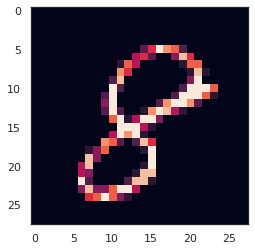

In [11]:
# Some examples
g = plt.imshow(X_train[0][:,:,0])  # 取第0个样本进行展示，[:,:,0]中0是指取颜色通道的第0个索引对应值，会将28*28*1 ->28*28

In [12]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

model = Sequential() # 序贯模型，用于搭网络模型

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))   # 1，卷积层1，32个5*5卷积核
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))   # 2， 卷积层2，32个5*5卷积核
model.add(MaxPool2D(pool_size=(2,2)))   # 3， 池化层1
model.add(Dropout(0.25))                # 4， 正则化1, dropout用于正则化项，随机丢失一些节点，防止网络过拟合


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))     # 5，卷积层3， 64个3*3卷积核
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))     # 6 卷积层4， 64个3*3卷积核
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))  # 7 池化层2
model.add(Dropout(0.25))     # 8 正则化2


model.add(Flatten())   # 9 展平，方便接全连接层
model.add(Dense(256, activation = "relu"))   # 10 全连接层1
model.add(Dropout(0.5))   # 11 正则化
model.add(Dense(10, activation = "softmax"))  # 12 全连接层2，softmax激活函数

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [13]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)  # 优化器

In [14]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])  # 编译模型，损失函数为交叉熵损失函数, 参数metrics=["accuracy"]用于评估模型的表现


Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [15]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)      # 对学习率（LR）使用退火算法, 为了更快的接近全局最小值，Loss大时LR大，之后逐步减小LR, 当准确率X步后不再提高，LR减半

In [16]:
epochs = 1 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 86

In [17]:
# Without data augmentation i obtained an accuracy of 0.98114
#history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
#          validation_data = (X_val, Y_val), verbose = 2)

In [18]:
# With data augmentation to prevent overfitting (accuracy 0.99286)
#为了防止过拟合问题，使用一些方法扩大我们的数据集。最理想的是使用一些小的变化改变训练数据。如：旋转、翻转、随机剪裁、缩放等


datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [19]:
# Fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])    # 模型训练

Epoch 1/1
 - 128s - loss: 0.4365 - acc: 0.8596 - val_loss: 0.0716 - val_acc: 0.9781


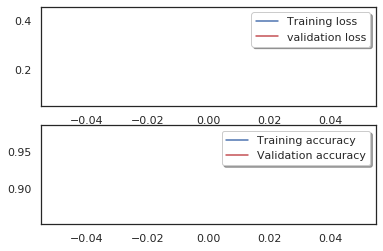

In [20]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)  # 画损失函数变化

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)  # 画准确率变化

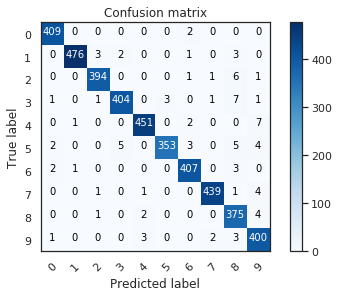

In [21]:
# Look at confusion matrix 画混淆矩阵

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)   # 画热力图
    plt.title(title)                     # 标题
    plt.colorbar()        # 设置颜色渐变条      
    tick_marks = np.arange(len(classes))   # 得到list,表示label
    plt.xticks(tick_marks, classes, rotation=45)   
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

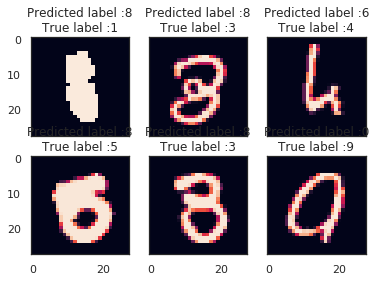

In [22]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

In [23]:
# predict results
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

In [24]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("cnn_mnist_datagen.csv",index=False)